# ImageNet Training - Local Version

This notebook is adapted for local machine execution (no Google Colab required).

## Key Changes:
- ✅ No Google Drive mounting required
- ✅ Uses local data paths (`./sample-data-train` and `./sample-data-val`)
- ✅ All checkpoints and logs saved locally

In [52]:
import sys
# Install essential packages one by one (more reliable)
!{sys.executable} -m pip install pandas --quiet
!{sys.executable} -m pip install matplotlib --quiet  
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118 --quiet

In [53]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

Libraries imported - ready to use PyTorch 2.7.1+cu118


In [54]:
# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device="cpu"

print(f"Using {device} device")

# resume training options
resume_training = True

class Params:
    def __init__(self):
        self.batch_size = 16
        self.name = "resnet_152_sgd1_local"  # Changed for local version
        self.workers = 4  # Adjust based on your CPU cores
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1

    def __repr__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
params = Params()
params, params.batch_size

Using cuda device


({'batch_size': 16, 'name': 'resnet_152_sgd1_local', 'workers': 4, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1},
 16)

In [55]:
import os, shutil
from pathlib import Path
import scipy.io as sio
from tqdm import tqdm

ROOT = Path('ILSVRC2012')  # <- change if needed
TRAIN_DIR = ROOT / 'train'        # e.g. .../train/n01440764/*.JPEG
VAL_FLAT  = ROOT / 'val'          # e.g. .../val/ILSVRC2012_val_00000001.JPEG
DEVKIT    = ROOT / 'devkit'       # .../devkit/data/meta.mat, ...ground_truth.txt
VAL_OUT   = ROOT / 'val_sorted'   # will create: val_sorted/<WNID>/*.JPEG

VAL_OUT.mkdir(parents=True, exist_ok=True)

# 1) ID -> WNID mapping from meta.mat
meta = sio.loadmat(str(DEVKIT / 'data' / 'meta.mat'), squeeze_me=True)['synsets']
id_to_wnid = {}
for entry in meta:
    ilsvrc_id = int(entry['ILSVRC2012_ID'])
    wnid = str(entry['WNID'])
    # keep only low-level (1..1000) classes
    if 1 <= ilsvrc_id <= 1000:
        id_to_wnid[ilsvrc_id] = wnid

# 2) GT labels (ILSVRC2012_ID per val image), aligned with alphabetical order of filenames
gt_path = DEVKIT / 'data' / 'ILSVRC2012_validation_ground_truth.txt'
gt_ids = [int(x) for x in open(gt_path).read().strip().splitlines()]

val_files = sorted([p for p in VAL_FLAT.glob('*.JPEG')])
assert len(val_files) == 50000, f"Expected 50k val images, got {len(val_files)}"
assert len(val_files) == len(gt_ids), "Mismatch between files and labels"

# 3) Copy into val_sorted/<WNID>/
for img_path, ilsvrc_id in tqdm(zip(val_files, gt_ids), total=len(val_files)):
    wnid = id_to_wnid[ilsvrc_id]
    dst_dir = VAL_OUT / wnid
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst = dst_dir / img_path.name
    if not dst.exists():
        shutil.copy2(img_path, dst)

print("Done building:", VAL_OUT)

100%|██████████| 50000/50000 [00:01<00:00, 25974.46it/s]

Done building: ILSVRC2012\val_sorted


In [56]:
# Local data paths - using ILSVRC2012 dataset structure
# Update the ROOT path to match your ILSVRC2012 location
from pathlib import Path

ROOT = Path('./ILSVRC2012')  # Change this to your ILSVRC2012 folder location
training_folder_name = str(ROOT / 'train')      # Training images in class folders
val_folder_name = str(ROOT / 'val_sorted')      # Validation images in class folders

# Alternative paths (uncomment if your structure is different):
# val_folder_name = str(ROOT / 'val')  # If using flat validation folder

# Verify paths exist
import os
if os.path.exists(training_folder_name):
    print(f"✓ Training data found: {training_folder_name}")
    num_classes = len([d for d in os.listdir(training_folder_name) if os.path.isdir(os.path.join(training_folder_name, d))])
    print(f"  Classes: {num_classes}")
else:
    print(f"✗ Training data not found at: {training_folder_name}")
    print(f"  Please update ROOT path or ensure ILSVRC2012 data is extracted")
    print(f"  Current ROOT: {ROOT}")

if os.path.exists(val_folder_name):
    print(f"✓ Validation data found: {val_folder_name}")
    if os.path.isdir(val_folder_name):
        items = os.listdir(val_folder_name)
        if items and os.path.isdir(os.path.join(val_folder_name, items[0])):
            print(f"  Validation data is organized in class folders")
        else:
            print(f"  Validation data appears to be flat - may need sorting")
else:
    print(f"✗ Validation data not found at: {val_folder_name}")
    print(f"  Please update ROOT path or run validation sorting script")
    print(f"  Current ROOT: {ROOT}")

✓ Training data found: ILSVRC2012\train
  Classes: 11
✓ Validation data found: ILSVRC2012\val_sorted
  Validation data is organized in class folders


In [6]:
os.listdir(training_folder_name)

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01518878',
 'n01530575']

In [57]:
os.listdir(val_folder_name)

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01518878',
 'n01530575',
 'n01531178',
 'n01532829',
 'n01534433',
 'n01537544',
 'n01558993',
 'n01560419',
 'n01580077',
 'n01582220',
 'n01592084',
 'n01601694',
 'n01608432',
 'n01614925',
 'n01616318',
 'n01622779',
 'n01629819',
 'n01630670',
 'n01631663',
 'n01632458',
 'n01632777',
 'n01641577',
 'n01644373',
 'n01644900',
 'n01664065',
 'n01665541',
 'n01667114',
 'n01667778',
 'n01669191',
 'n01675722',
 'n01677366',
 'n01682714',
 'n01685808',
 'n01687978',
 'n01688243',
 'n01689811',
 'n01692333',
 'n01693334',
 'n01694178',
 'n01695060',
 'n01697457',
 'n01698640',
 'n01704323',
 'n01728572',
 'n01728920',
 'n01729322',
 'n01729977',
 'n01734418',
 'n01735189',
 'n01737021',
 'n01739381',
 'n01740131',
 'n01742172',
 'n01744401',
 'n01748264',
 'n01749939',
 'n01751748',
 'n01753488',
 'n01755581',
 'n01756291',
 'n01768244',
 'n01770081',
 'n017

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2360556..1.764348].


torch.Size([16, 3, 224, 224])


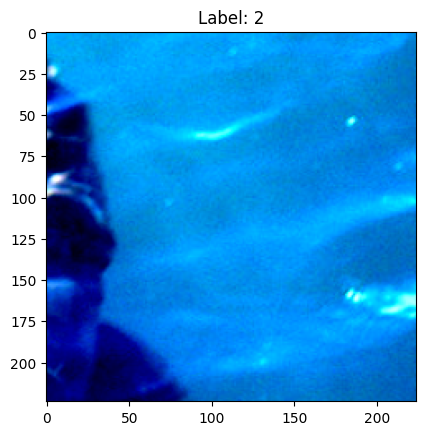

In [58]:
train_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True,
)
for X, y in train_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [59]:
train_dataset[1337]

(tensor([[[ 1.1456,  1.1002,  1.0977,  ...,  1.9582,  1.9166,  2.0479],
          [ 1.0509,  1.2172,  1.2223,  ...,  1.9180,  1.8921,  1.8776],
          [ 0.9977,  1.0400,  1.0374,  ...,  1.7894,  1.8594,  1.9037],
          ...,
          [-0.9720, -0.9051, -0.8872,  ..., -0.7137, -0.8505, -1.0631],
          [-1.2885, -0.9255, -0.7409,  ..., -0.7590, -0.9650, -1.1378],
          [-1.2151, -0.9594, -0.8939,  ..., -0.8975, -0.7878, -0.7728]],
 
         [[-0.4325, -0.4646, -0.4603,  ...,  1.3492,  1.4570,  1.4603],
          [-0.2363, -0.2245, -0.3376,  ...,  1.2468,  1.3146,  1.2473],
          [-0.2087, -0.1285, -0.0941,  ...,  1.1591,  1.2751,  1.2893],
          ...,
          [-0.9901, -0.9452, -0.9704,  ..., -1.0024, -0.9156, -0.9639],
          [-1.0319, -0.9630, -1.0472,  ..., -0.9697, -0.9000, -0.9279],
          [-1.0647, -1.1396, -1.0741,  ..., -0.9900, -0.9353, -1.2236]],
 
         [[-0.7419, -0.8918, -1.0113,  ...,  2.1757,  2.1691,  2.3076],
          [-1.0012, -0.5043,

In [61]:
# Filter validation dataset to only include classes present in training data
# This prevents class mismatch errors
from torch.utils.data import Subset

print(f"Original validation size: {len(val_dataset)}")
print(f"Training classes: {len(train_dataset.classes)}")
print(f"Validation classes: {len(val_dataset.classes)}")

# If class counts don't match, filter validation data
if len(train_dataset.classes) != len(val_dataset.classes):
    print("\n⚠️  Class mismatch detected!")
    print("Filtering validation data to match training classes...")
    
    # Get indices of validation samples that match training classes
    valid_indices = [i for i, (_, label) in enumerate(val_dataset) 
                     if label < len(train_dataset.classes)]
    
    # Create filtered validation dataset
    val_dataset_filtered = Subset(val_dataset, valid_indices)
    
    # Recreate validation loader with filtered dataset
    val_loader = torch.utils.data.DataLoader(
        val_dataset_filtered,
        batch_size=64,
        num_workers=params.workers,
        shuffle=False,
        pin_memory=True
    )
    
    print(f"✅ Filtered validation size: {len(val_dataset_filtered)}")
    print(f"   Valid labels: 0 to {len(train_dataset.classes)-1}")
else:
    print("✅ Class counts match - no filtering needed")


Original validation size: 50000
Training classes: 11
Validation classes: 1000

⚠️  Class mismatch detected!
Filtering validation data to match training classes...
✅ Filtered validation size: 550
   Valid labels: 0 to 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6654462..2.5299704].


torch.Size([64, 3, 224, 224])


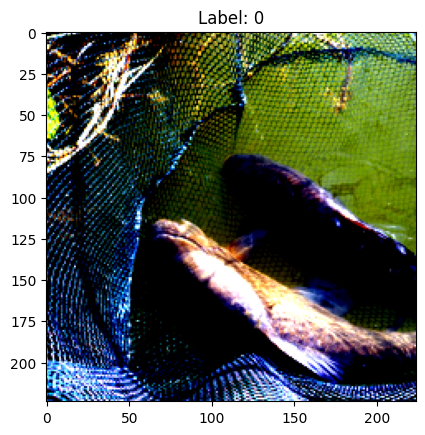

In [60]:
val_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=256, antialias=True),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
print(X.shape)
show_image(X[0], y[0])

📊 EDA on ImageNet Subset
----------------------------------------
Total Training Images: 14300
Total Validation Images: 50000
Number of Classes: 11

Sample Class Names: ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878'] 



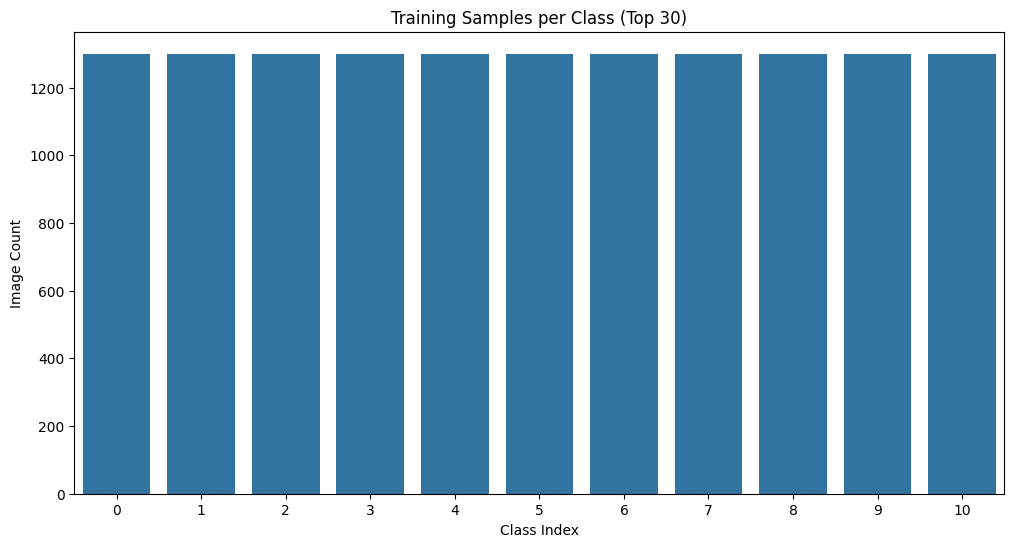


🖼️ Sample Images from Training Set:


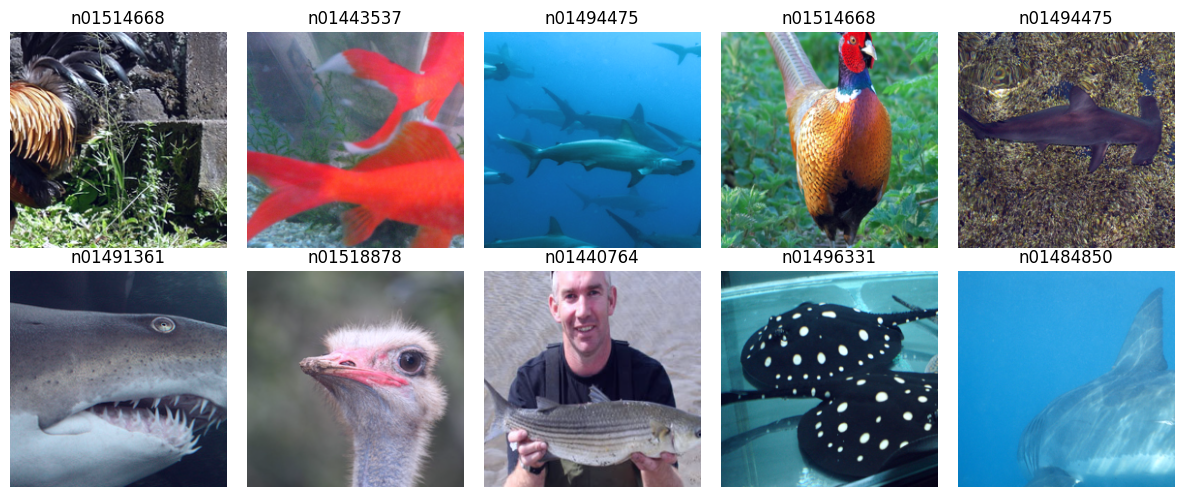

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

def dataset_eda(train_dataset, val_dataset):
    print("📊 EDA on ImageNet Subset")
    print("-" * 40)
    print(f"Total Training Images: {len(train_dataset)}")
    print(f"Total Validation Images: {len(val_dataset)}")
    print(f"Number of Classes: {len(train_dataset.classes)}\n")

    # Print first few class names
    print("Sample Class Names:", train_dataset.classes[:10], "\n")

    # Count images per class
    train_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset))])
    val_counts = Counter([val_dataset.targets[i] for i in range(len(val_dataset))])

    # Convert to sorted lists for visualization
    class_indices = list(range(len(train_dataset.classes)))
    train_freqs = [train_counts[i] for i in class_indices]
    val_freqs = [val_counts[i] for i in class_indices]

    # Plot class distribution (Top 30 only for readability)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(range(min(30, len(train_freqs)))), y=train_freqs[:30])
    plt.title("Training Samples per Class (Top 30)")
    plt.xlabel("Class Index")
    plt.ylabel("Image Count")
    plt.show()

    # Show a few sample images
    print("\n🖼️ Sample Images from Training Set:")
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(len(train_dataset))
        img, label = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip((img * 0.229 + 0.485), 0, 1)  # De-normalize for viewing
        ax.imshow(img)
        ax.set_title(train_dataset.classes[label][:15])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Run EDA
dataset_eda(train_dataset, val_dataset)


In [64]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [42]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
## testing a pretrained model to validate correctness of our dataset, transform and metrics code
pretrained_model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
start = time.time()
loss_fn = nn.CrossEntropyLoss()
test(val_loader, pretrained_model, loss_fn, epoch=0, writer=None, train_dataloader=train_loader, calc_acc5=True)
print("Elapsed: ", time.time() - start)

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.771854 

Test Error: 
 Accuracy-5: 94.9%, Avg loss: 0.771854 

Elapsed:  8.675155401229858


In [66]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups,
        bias=False,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [67]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        base_width: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [68]:
# Debug: Check dataset and model configuration
print("="*60)
print("Dataset Information:")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of classes detected: {len(train_dataset.classes)}")
print(f"Class names (first 10): {train_dataset.classes[:10]}")
print(f"Label range in train: {min(train_dataset.targets)} to {max(train_dataset.targets)}")
print(f"Label range in val: {min(val_dataset.targets)} to {max(val_dataset.targets)}")
print("="*60)


Dataset Information:
Training dataset size: 14300
Validation dataset size: 50000
Number of classes detected: 11
Class names (first 10): ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878']
Label range in train: 0 to 10
Label range in val: 0 to 999


In [69]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Bottleneck],
        layers: List[int],
        num_classes: int = 1000,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.base_width, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [77]:
# Create ResNet152 model (layers: [3, 8, 36, 3])
# Adjust num_classes based on your dataset
num_classes = len(train_dataset.classes)
print(f"Creating ResNet152 with {num_classes} classes")

model = ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes).to(device)

# Test forward pass
preds = model(X.to(device))
print(f"Model output shape: {preds.shape}")
preds.shape

Creating ResNet152 with 11 classes
Model output shape: torch.Size([64, 11])


torch.Size([64, 11])

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=params.lr, momentum=params.momentum, weight_decay=params.weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)

In [80]:
start_epoch = 0
checkpoint_path = os.path.join("checkpoints", params.name, f"checkpoint.pth")

# Set to False to force fresh training (ignore checkpoints)
FORCE_FRESH_START = False  # Change to True to start over

if resume_training and os.path.exists(checkpoint_path) and not FORCE_FRESH_START:
    try:
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)  # map_location ensures device compatibility
        model.load_state_dict(checkpoint["model"])
        start_epoch = checkpoint["epoch"] + 1
        optimizer.load_state_dict(checkpoint["optimizer"])
        lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
        assert params == checkpoint["params"], "Parameters changed since checkpoint was saved!"
        print(f"✅ Resumed from epoch {start_epoch}")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("Starting training from scratch instead...")
        start_epoch = 0
else:
    if FORCE_FRESH_START:
        print("🔄 FORCE_FRESH_START enabled - ignoring checkpoint")
    print("Starting training from scratch")

Loading checkpoint from checkpoints\resnet_152_sgd1_local\checkpoint.pth
⚠️ Error loading checkpoint: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Params was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.Params])` or the `torch.serialization.safe_globals([__main__.Params])` context manager to allowlist this global if you trust this class/function.

Check the do

In [24]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

# Create directories for checkpoints and logs
Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)

print(f"TensorBoard logs will be saved to: runs/{params.name}")
print(f"Checkpoints will be saved to: checkpoints/{params.name}")
print("\nTo view training progress, run: tensorboard --logdir=runs")
print("="*60)

# Initial validation
print("\n🔍 Initial validation:")
test(val_loader, model, loss_fn, epoch=0, writer=writer, train_dataloader=train_loader, calc_acc5=True)

# Training loop
num_epochs = 100
print(f"\n🚀 Starting training for {num_epochs} epochs (from epoch {start_epoch})...")

for epoch in range(start_epoch, num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    # Train
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    
    # Save checkpoint
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params
    }
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"checkpoint.pth"))
    
    # Update learning rate
    lr_scheduler.step()
    
    # Validate
    print(f"\n🔍 Validation after epoch {epoch+1}:")
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)

writer.close()
print("\n✅ Training complete!")

TensorBoard logs will be saved to: runs/resnet_152_sgd1_local
Checkpoints will be saved to: checkpoints/resnet_152_sgd1_local

To view training progress, run: tensorboard --logdir=runs

🔍 Initial validation:
Test Error: 
 Accuracy: 7.6%, Avg loss: 16.396859 

Test Error: 
 Accuracy-5: 45.5%, Avg loss: 16.396859 


🚀 Starting training for 100 epochs (from epoch 0)...

Epoch 1/100
loss: 2.737440  [   16/14300], 0.111888%
loss: 2.579573  [ 1616/14300], 11.300699%
Done in  8.577670574188232  seconds
Remaining time (seconds):  67.99948347687722
loss: 2.371398  [ 3216/14300], 22.489510%
Done in  8.501609802246094  seconds
Remaining time (seconds):  58.89490190505982
loss: 2.377690  [ 4816/14300], 33.678322%
Done in  8.508385181427002  seconds
Remaining time (seconds):  50.433453162908556
loss: 2.480069  [ 6416/14300], 44.867133%
Done in  8.54138445854187  seconds
Remaining time (seconds):  42.08767191946506
loss: 2.309644  [ 8016/14300], 56.055944%
Done in  8.589945316314697  seconds
Remaini